## Weersvoorspelling Maastricht juni 2020

In deze casus wordt er voorspelt wat de neerslag en de temperatuur zal zijn in Maastricht. Deze voorspelling wordt gedaan voor de maand juni in 2020.

#### Referentie:
KNMI http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi

### Team: 6
1. Florian Maters,
2. Kento Bergsma,
3. David van der Zande,
4. Ahasan Rajaratnam

### Versies van de gebruikte libraries
- Pandas: 0.25.1
- Numpy: 1.16.5
- Sklearn: 0.21.3
- Matplotlib: 3.1.1
- Seaborn: 0.9.0

# Description
YYYYMMDD = Datum (YYYY=jaar MM=maand DD=dag)<br>
http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi

### Temperatuur
TG = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)<br> 
TN = Minimum temperatuur (in 0.1 graden Celsius)<br>
TNH = Uurvak waarin TN is gemeten<br>
TX = Maximum temperatuur (in 0.1 graden Celsius)<br>
TXH = Uurvak waarin TX is gemeten<br>
### Neerslag
DR = Duur van de neerslag (in 0.1 uur)<br>
RH = Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)<br>
RHX = Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)<br> 
RHXH = Uurvak waarin RHX is gemeten

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib 
import seaborn as sns


# Machine Learning
from sklearn import preprocessing, svm, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

### Data ophalen
1. Data in dataframe
2. Locatie in dataframe
3. Samenvoegen van dataframes

In [2]:
df = pd.read_csv('data/maastricht.csv', low_memory=False)
df1 = pd.read_csv('data/location.csv')
df['STN'] = df['STN'].map(df1.set_index('STN')['NAME'])

### Kolommen
1. Kolommen selecteren die we gaan gebruiken
2. Datum overzichtelijk maken
    1. Jaar kolom maken
    2. Maand kolom maken
    3. Dag kolom maken

In [3]:
df = df[['STN', 'YYYYMMDD', 'TG', 'TN', 'TNH', 'TX', 'TXH', 'DR', 'RH', 'RHX', 'RHXH' ]]
df['Datum'] = df['YYYYMMDD'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

df['Jaar'] = pd.DatetimeIndex(df['Datum']).year
df['Maand'] = pd.DatetimeIndex(df['Datum']).month
df['Dag'] = pd.DatetimeIndex(df['Datum']).day

### Data omvormen
1. Minimale, maximale en gemiddelde temperatuur omgezet naar hele graden Celcius
2. Duur van neerslag omgezet naar hele uren.
3. Alleen maand juni laten zien die wij gaan gebruiken

In [4]:
df['TN'] *= 0.1
df['TX'] *= 0.1
df['TG'] *= 0.1

df['DR'] *= 0.1

df = df[df['Maand'] == 6]

### Data weergeven

In [5]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3420 entries, 151 to 41453
Data columns (total 15 columns):
STN         3420 non-null object
YYYYMMDD    3420 non-null int64
TG          3420 non-null float64
TN          3420 non-null float64
TNH         2070 non-null float64
TX          3420 non-null float64
TXH         2070 non-null float64
DR          1890 non-null float64
RH          1890 non-null float64
RHX         1890 non-null float64
RHXH        786 non-null float64
Datum       3420 non-null datetime64[ns]
Jaar        3420 non-null int64
Maand       3420 non-null int64
Dag         3420 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(4), object(1)
memory usage: 427.5+ KB
None


,STN,YYYYMMDD,TG,TN,TNH,TX,TXH,DR,RH,RHX,RHXH,Datum,Jaar,Maand,Dag
151,MAASTRICHT,19060601,10.3,7.5,NaN,13.7,NaN,NaN,NaN,NaN,NaN,1906-06-01,1906,6,1
152,MAASTRICHT,19060602,9.8,6.0,NaN,13.8,NaN,NaN,NaN,NaN,NaN,1906-06-02,1906,6,2
153,MAASTRICHT,19060603,9.3,7.7,NaN,12.2,NaN,NaN,NaN,NaN,NaN,1906-06-03,1906,6,3
154,MAASTRICHT,19060604,9.7,7.6,NaN,12.3,NaN,NaN,NaN,NaN,NaN,1906-06-04,1906,6,4
155,MAASTRICHT,19060605,9.8,5.6,NaN,14.9,NaN,NaN,NaN,NaN,NaN,1906-06-05,1906,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41449,MAASTRICHT,20190626,23.4,18.1,24.0,28.9,15.0,0.0,0.0,0.0,1.0,2019-06-26,2019,6,26
41450,MAASTRICHT,20190627,19.7,14.4,4.0,26.2,15.0,0.0,0.0,0.0,1.0,2019-06-27,2019,6,27
41451,MAASTRICHT,20190628,19.5,11.9,4.0,26.5,16.0,0.0,0.0,0.0,1.0,2019-06-28,2019,6,28
41452,MAASTRICHT,20190629,25.4,13.0,4.0,33.7,16.0,0.0,0.0,0.0,1.0,2019-06-29,2019,6,29


### Plotten van de minimum temperatuur over de jaren heen
1. Nodige kolommen selecteren om temperatuur te berekenen
2. Nodige kolommen selecteren om minimum temperatuur te berekenen
3. Berekenen gemiddelde minimum temperatuur per maand
4. Plotten van minimum temperatuur per maand

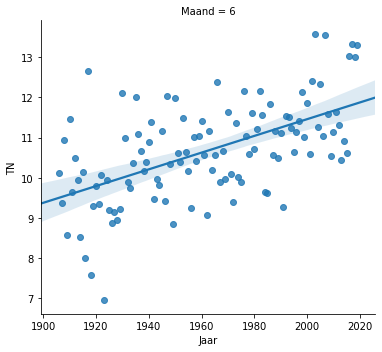

In [6]:
dfTemp = df[['YYYYMMDD', 'Datum', 'TN', 'TX', 'TG', 'Jaar', 'Maand', 'Dag']]
dfTempMin = dfTemp[['Datum', 'TN', 'Jaar', 'Maand', 'Dag']]
dfTempMinMean = dfTempMin.groupby(['Jaar', 'Maand'],as_index=False)['TN'].mean()
sns.lmplot(x='Jaar', y='TN', data=dfTempMinMean, col="Maand", col_wrap=3)

### Plotten van de maximum temperatuur over de jaren heen
1. Nodige kolommen selecteren om maximum temperatuur te berekenen
2. Berekenen gemiddelde maximum temperatuur per maand
3. Plotten van maximum temperatuur per maand

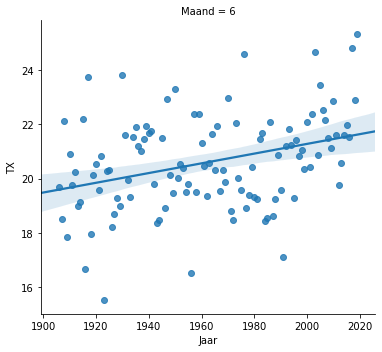

In [7]:
dfTempMax = dfTemp[['Datum', 'TX', 'Jaar', 'Maand', 'Dag']]
dfTempMaxMean = dfTempMax.groupby(['Jaar', 'Maand'],as_index=False)['TX'].mean()
sns.lmplot(x='Jaar', y='TX', data=dfTempMaxMean, col="Maand", col_wrap=3)

### Plotten van de gemiddelde temperatuur over de jaren heen
1. Nodige kolommen selecteren om de gemiddelde temperatuur te berekenen
2. Gemiddelde temperatuur berekenen per maand
3. Plotten van gemiddelde temperatuur per maand

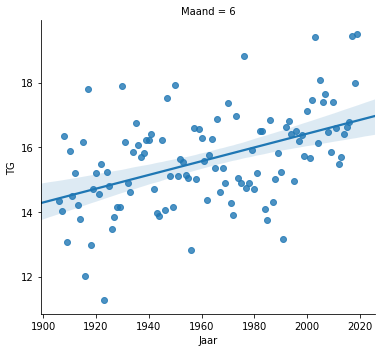

In [8]:
dfTempGem = dfTemp[['Datum', 'TG', 'Jaar', 'Maand', 'Dag']]
dfTempGemMean = dfTempGem.groupby(['Jaar', 'Maand'],as_index=False)['TG'].mean()
sns.lmplot(x='Jaar', y='TG', data=dfTempGemMean, col="Maand", col_wrap=3)

### Plotten van de gemiddelde neerslag over de jaren heen
1. Nodige kolommen selecteren om gemiddelde neerslag te berekenen
2. Nodige kolommen selecteren om gemiddelde neerslag te berekenen per maand
3. Lege data uit de dataframe weghalen
4. Plotten van de gemiddelde temperatuur per maand

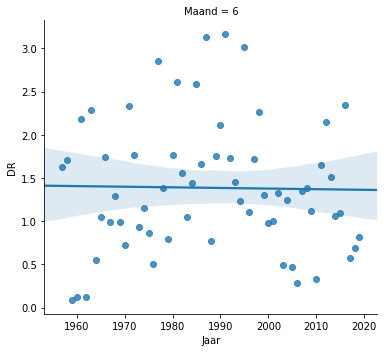

In [10]:
dfRegen = df[['YYYYMMDD', 'Datum', 'DR', 'Jaar', 'Maand', 'Dag']]
dfRegenMean = dfRegen.groupby(['Jaar', 'Maand'],as_index=False)['DR'].mean()
dfRegenMean = dfRegenMean.dropna()
sns.lmplot(x='Jaar', y='DR', data=dfRegenMean, col='Maand', col_wrap=3)

# Temperatuur
### Test en train data splitsen voor gemiddelde temperatuur
1. Dataset shuffle om random test en train data te krijgen
2. X en Y as opsplitsen
3. Ratio berekenen voor 80% train data en 20% test data
4. Data splitsen in train en test data

In [11]:
dfRandomOrderTemp = dfTempGemMean.sample(frac=1).reset_index(drop=True)

dataXTemp = dfRandomOrderTemp['Jaar'].to_numpy()
dataXTemp = np.reshape(dataXTemp, (-1, 1))
dataYTemp = dfRandomOrderTemp['TG'].to_numpy()

ratio = round(len(dataXTemp) * 0.8)

train_x = dataXTemp[:ratio]
train_y = dataYTemp[:ratio]

test_x = dataXTemp[ratio:]
test_y = dataYTemp[ratio:]

### Regressiemodel toepassen
1. Lineair model opstellen
2. Model trainen met trainings dataset
3. Mediaan berekenen van de testdata

In [12]:
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)

YPredTemp = regr.predict(test_x)

### Berekeningen maken voor plotten
1. Berekenen van de coeficient
2. Berekenen van de mogelijke kwadratische afwijking van de voorspelling
3. Berekenen van de nauwkeurigheid
4. Voorspelling maken voor juni 2020

In [13]:
print('Coefficients: \n', regr.coef_)

print('Mean squared error: %.2f'
      % mean_squared_error(test_y, YPredTemp))

print('Coefficient of determination: %.2f'
      % r2_score(test_y, YPredTemp))

print('Gemiddelde temp juni 2020: %.2f'
      % regr.predict(X=[[2020]]))

Coefficients: 
 [0.02324691]
Mean squared error: 1.09
Coefficient of determination: 0.04
Gemiddelde temp juni 2020: 17.00


### Plotten van data
1. Zwarte punten is bekende data
2. Blauwe lijn is mediaan
3. Oranje punt is voorspelling voor juni 2020

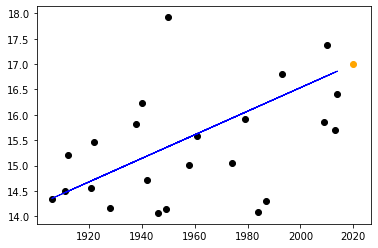

In [14]:
plt.scatter(test_x, test_y, color='black')
plt.plot(test_x, YPredTemp, color='blue', linewidth=1)
plt.scatter(2020, regr.predict(X=[[2020]]), color='orange')

plt.show()

# Neerslag
### Test en train data splitsen voor gemiddelde neerslag
1. Dataset shuffle om random test en train data te krijgen
2. X en Y as opsplitsen
3. Ratio berekenen voor 80% train data en 20% test data
4. Data splitsen in train en test data

In [15]:
dfRandomOrderRegen = dfRegenMean.sample(frac=1).reset_index(drop=True)

dataXRegen = dfRandomOrderRegen['Jaar'].to_numpy()
dataXRegen = np.reshape(dataXRegen, (-1, 1))
dataYRegen = dfRandomOrderRegen['DR'].to_numpy()

ratio = round(len(dataXRegen) * 0.8)

train_x = dataXRegen[:ratio]
train_y = dataYRegen[:ratio]

test_x = dataXRegen[ratio:]
test_y = dataYRegen[ratio:]

### Regressiemodel toepassen
1. Lineair model opstellen
2. Model trainen met trainings dataset
3. Mediaan berekenen van de testdata

In [16]:
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)

YPredRegen = regr.predict(test_x)

### Berekeningen maken voor plotten
1. Berekenen van de coeficient
2. Berekenen van de mogelijke kwadratische afwijking van de voorspelling
3. Berekenen van de nauwkeurigheid
4. Voorspelling maken voor juni 2020

In [17]:
print('Coefficients: \n', regr.coef_)

print('Mean squared error: %.2f'
      % mean_squared_error(test_y, YPredRegen))

print('Coefficient of determination: %.2f'
      % r2_score(test_y, YPredRegen))

print('Gemiddelde duur van regen in juni 2020 in uren: %.2f'
      % regr.predict(X=[[2020]]))

Coefficients: 
 [0.0030914]
Mean squared error: 0.64
Coefficient of determination: -0.19
Gemiddelde duur van regen in juni 2020 in uren: 1.43


### Plotten van data
1. Zwarte punten is bekende data
2. Blauwe lijn is mediaan
3. Oranje punt is voorspelling voor juni 2020

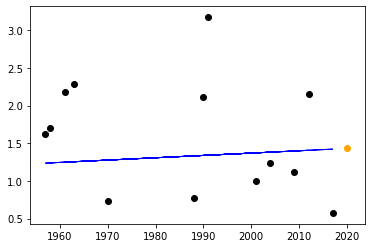

In [18]:
plt.scatter(test_x, test_y, color='black')
plt.plot(test_x, YPredRegen, color='blue', linewidth=1)
plt.scatter(2020, regr.predict(X=[[2020]]), color='orange')

plt.show()

## Conclusie:
Met behulp van onze onderzoek voorspellen wij dat de gemiddelde duur van regen in Maastricht in Juni 2020 ±1.5 uren zal zijn en de gemiddelde temperatuur ±17 °C. <br> Dit is natuurlijk berekend op basis van het gemiddelde van de afgelopen jaren.<br> Zoals je in de grafieken terug ziet zijn er een heleboel punten die afwijken van het gemiddelde. <br>Hierdoor is het bijna onmogelijk om te voorspellen wat de neerslagduur en de gemiddelde temperatuur zal zijn